In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Conv1D, LSTM, Flatten, concatenate, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
df = pd.read_csv('clustered_data_new.csv')

# Data Preprocessing
def fill_NAs(df):
    df_cleaned = df.copy()

    # Fill missing values
    average_count_week_instock = df_cleaned.groupby(['Item_Code', 'Market_Name'])['Count_Week_Instock'].transform('mean')
    df_cleaned['Count_Week_Instock'] = df_cleaned['Count_Week_Instock'].fillna(average_count_week_instock)
    df_cleaned['Market_Sales_L52wk'] = df_cleaned.groupby(['Item_Code'])['Market_Sales_L52wk'].transform(
        lambda x: x.fillna(x.mean()))
    df_cleaned['Market_Sales_L52wk'] = df_cleaned['Market_Sales_L52wk'].fillna(
        df_cleaned.groupby(['Item_Code'])['Normalized_Sales_$L52W'].transform('mean'))

    return df_cleaned

df_cleaned = fill_NAs(df)

# Log-transform certain columns
columns_to_log = ['Retail_Price', 'Households', 'Store_Age_Days',
                  'Normalized_Sales_$L52W', 'Market_Sales_L52wk']

for column in columns_to_log:
    df_cleaned['log_' + column] = np.log(df_cleaned[column] + 1e-6)

# Remove features that cannot be created due to missing base columns

# Split the data into 'data' and 'pred' based on 'Sales Bucket'
data = df_cleaned[df_cleaned['Sales Bucket'] == 'Sales included']
pred = df_cleaned[df_cleaned['Sales Bucket'] == 'Sales excluded for model test']

# Define the features and target for 'data'
X = data[['Vodka', 'Store_Size_Extra Large',
          'Store_Size_Large', 'Store_Size_Medium', 'Store_Size_Small', 'Store_State_AZ', 'Store_State_CA',
          'Store_State_CO', 'Store_State_CT', 'Store_State_DE', 'Store_State_FL', 'Store_State_GA',
          'Store_State_IL', 'Store_State_IN', 'Store_State_KS', 'Store_State_KY', 'Store_State_LA',
          'Store_State_MA', 'Store_State_MD', 'Store_State_MI', 'Store_State_MN', 'Store_State_MO',
          'Store_State_NJ', 'Store_State_NM', 'Store_State_NV', 'Store_State_NY', 'Store_State_SC',
          'Store_State_TN', 'Store_State_TX', 'Store_State_WA', 'Store_State_WI', 'Package_Type_1.5L',
          'Package_Type_1.75L', 'Package_Type_1.75Lgft', 'Package_Type_100ml', 'Package_Type_1L',
          'Package_Type_200-3gft', 'Package_Type_200ml', 'Package_Type_375ml', 'Package_Type_700ml',
          'Package_Type_720ml', 'Package_Type_750gft', 'Package_Type_750ml', 'Count_Week_Instock_Normalized',
          'log_Retail_Price', 'log_Households', 'log_Store_Age_Days', 'Cluster_Label'
          ]]
y = data['Normalized_Sales_$L52W']

# Verify that all columns exist
missing_cols = [col for col in X.columns if col not in data.columns]
if missing_cols:
    print("Missing columns:", missing_cols)
else:
    print("All columns are present.")

# Split into train, validation, and holdout sets
X_train_val, X_holdout, y_train_val, y_holdout = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Preprocessing pipeline
numerical_features = ['Vodka', 'Count_Week_Instock_Normalized', 'log_Retail_Price',
                      'log_Households', 'log_Store_Age_Days']

categorical_features = ['Store_Size_Extra Large', 'Store_Size_Large', 'Store_Size_Medium',
                        'Store_Size_Small', 'Store_State_AZ', 'Store_State_CA', 'Store_State_CO',
                        'Store_State_CT', 'Store_State_DE', 'Store_State_FL', 'Store_State_GA',
                        'Store_State_IL', 'Store_State_IN', 'Store_State_KS', 'Store_State_KY',
                        'Store_State_LA', 'Store_State_MA', 'Store_State_MD', 'Store_State_MI',
                        'Store_State_MN', 'Store_State_MO', 'Store_State_NJ', 'Store_State_NM',
                        'Store_State_NV', 'Store_State_NY', 'Store_State_SC', 'Store_State_TN',
                        'Store_State_TX', 'Store_State_WA', 'Store_State_WI', 'Package_Type_1.5L',
                        'Package_Type_1.75L', 'Package_Type_1.75Lgft', 'Package_Type_100ml',
                        'Package_Type_1L', 'Package_Type_200-3gft', 'Package_Type_200ml',
                        'Package_Type_375ml', 'Package_Type_700ml', 'Package_Type_720ml',
                        'Package_Type_750gft', 'Package_Type_750ml', 'Cluster_Label']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', 'passthrough', categorical_features)
    ])

# Preprocess data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_holdout_preprocessed = preprocessor.transform(X_holdout)


All columns are present.


In [2]:
# For LSTM
timesteps = 1  # Since we don't have a sequential time series, we can set timesteps to 1
features = X_train_preprocessed.shape[1]

X_train_lstm = X_train_preprocessed.reshape((X_train_preprocessed.shape[0], timesteps, features))
X_val_lstm = X_val_preprocessed.reshape((X_val_preprocessed.shape[0], timesteps, features))
X_holdout_lstm = X_holdout_preprocessed.reshape((X_holdout_preprocessed.shape[0], timesteps, features))

# For CNN
X_train_cnn = X_train_preprocessed.reshape((X_train_preprocessed.shape[0], features, 1))
X_val_cnn = X_val_preprocessed.reshape((X_val_preprocessed.shape[0], features, 1))
X_holdout_cnn = X_holdout_preprocessed.reshape((X_holdout_preprocessed.shape[0], features, 1))


In [3]:
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Conv1D, Flatten, concatenate, BatchNormalization

# Input layers
input_ann = Input(shape=(features,), name='ann_input')
input_lstm = Input(shape=(timesteps, features), name='lstm_input')
input_cnn = Input(shape=(features, 1), name='cnn_input')

# ANN Branch
ann_branch = Dense(128, activation='relu')(input_ann)
ann_branch = BatchNormalization()(ann_branch)
ann_branch = Dropout(0.3)(ann_branch)
ann_branch = Dense(64, activation='relu')(ann_branch)
ann_branch = BatchNormalization()(ann_branch)
ann_branch = Dropout(0.3)(ann_branch)

# LSTM Branch
lstm_branch = LSTM(64, return_sequences=False)(input_lstm)
lstm_branch = BatchNormalization()(lstm_branch)
lstm_branch = Dropout(0.3)(lstm_branch)

# CNN Branch
cnn_branch = Conv1D(filters=64, kernel_size=3, activation='relu')(input_cnn)
cnn_branch = BatchNormalization()(cnn_branch)
cnn_branch = Dropout(0.3)(cnn_branch)
cnn_branch = Flatten()(cnn_branch)
cnn_branch = Dense(64, activation='relu')(cnn_branch)
cnn_branch = BatchNormalization()(cnn_branch)
cnn_branch = Dropout(0.3)(cnn_branch)

# Concatenate branches
combined = concatenate([ann_branch, lstm_branch, cnn_branch])

# Fully connected layers
combined = Dense(128, activation='relu')(combined)
combined = BatchNormalization()(combined)
combined = Dropout(0.4)(combined)
combined = Dense(64, activation='relu')(combined)
combined = BatchNormalization()(combined)
combined = Dropout(0.4)(combined)
output = Dense(1, activation='linear')(combined)

# Define the model
model = Model(inputs=[input_ann, input_lstm, input_cnn], outputs=output)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ cnn_input (InputLayer)    │ (None, 48, 1)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ann_input (InputLayer)    │ (None, 48)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 46, 64)         │            256 │ cnn_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │          6,272 │ ann_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 46, 64)         │            256 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128)            │            512 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 46, 64)         │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_input (InputLayer)   │ (None, 1, 48)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 2944)           │              0 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 64)             │         28,928 │ lstm_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │        188,480 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64)             │            256 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64)             │            256 │ lstm[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 64)             │            256 │ dense_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ batch_normalization_1… │
├──────────────────────

 Total params: 267,521 (1.02 MB)

 Trainable params: 266,369 (1.02 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [4]:
# Implement early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    [X_train_preprocessed, X_train_lstm, X_train_cnn],
    y_train,
    epochs=200,
    batch_size=32,
    validation_data=([X_val_preprocessed, X_val_lstm, X_val_cnn], y_val),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/200
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 334102656.0000 - mae: 3915.2400 - val_loss: 316714400.0000 - val_mae: 4134.8101
Epoch 2/200
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 232469040.0000 - mae: 3728.1870 - val_loss: 315722240.0000 - val_mae: 4089.0647
Epoch 3/200
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 249074624.0000 - mae: 3809.9351 - val_loss: 314297024.0000 - val_mae: 4016.4824
Epoch 4/200
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 337146016.0000 - mae: 3919.6519 - val_loss: 312669664.0000 - val_mae: 3928.8914
Epoch 5/200
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 267911696.0000 - mae: 3766.7249 - val_loss: 310519488.0000 - val_mae: 3822.0261
Epoch 6/200
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 225490816.0000 - mae: 3470.2883 - val_loss: 308133056.0000 - val_mae: 3724.0222
Epoch 7/200
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 238245488.0000 - mae: 3466.4729 - val_loss: 305471552.0000 - val_

In [5]:
# Evaluate the model
y_train_pred = model.predict([X_train_preprocessed, X_train_lstm, X_train_cnn]).flatten()
y_val_pred = model.predict([X_val_preprocessed, X_val_lstm, X_val_cnn]).flatten()
y_holdout_pred = model.predict([X_holdout_preprocessed, X_holdout_lstm, X_holdout_cnn]).flatten()

# Metrics
def evaluate_model(y_true, y_pred, set_name):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{set_name} RMSE: {rmse:.4f}")
    print(f"{set_name} MAE: {mae:.4f}")
    print(f"{set_name} R²: {r2:.4f}")

print("ANN + LSTM + CNN Model Performance:")
evaluate_model(y_train, y_train_pred, "Training")
evaluate_model(y_val, y_val_pred, "Validation")
evaluate_model(y_holdout, y_holdout_pred, "Holdout")


1236/1236 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
ANN + LSTM + CNN Model Performance:
Training RMSE: 13751.9853
Training MAE: 3801.9999
Training R²: 0.3148
Validation RMSE: 14802.8795
Validation MAE: 4089.8648
Validation R²: 0.2695
Holdout RMSE: 15673.9459
Holdout MAE: 4074.2346
Holdout R²: 0.3057


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


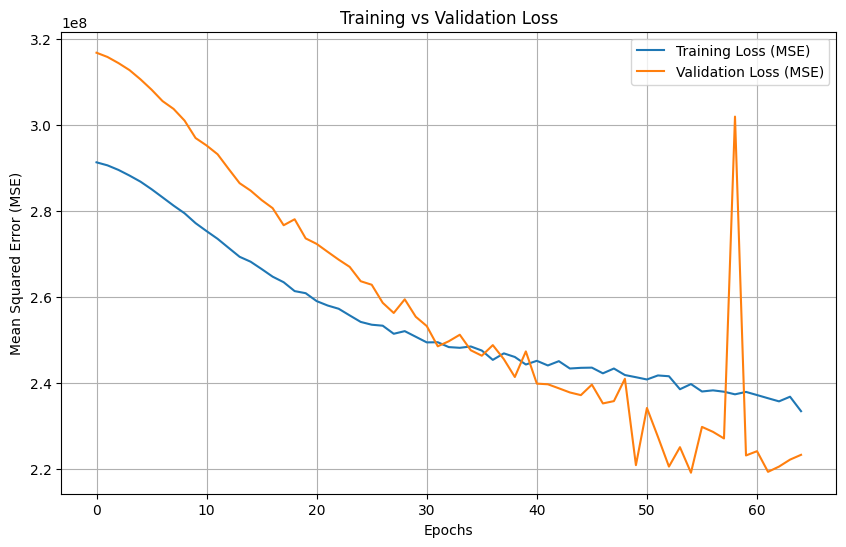

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
!pip install tensorflow
!pip install pandas
!pip install scikit-learn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Conv1D, MaxPooling1D, LSTM, concatenate, Flatten, Lambda
)
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving clustered_data.csv to clustered_data.csv
User uploaded file "clustered_data.csv" with length 39956432 bytes


In [2]:
final = pd.read_csv('clustered_data.csv')

# Display initial columns
print("Initial columns:", final.columns.tolist())

# Define columns to encode (categorical variables)
columns_to_encode = ['Store_Number', 'Item_Code', 'Market_Name']

# One-hot encode categorical features
final = pd.get_dummies(final, columns=columns_to_encode, drop_first=True)

# Drop irrelevant columns (including text columns)
columns_to_drop = [
    'Item_Name', 'Count_Week_Instock', 'Store_Address',
    'Store_Name', 'Open_Date', 'index', 'Normalized_Sales_$L52W'
]
final = final.drop(columns=columns_to_drop, errors='ignore')

# Replace boolean values with integers
final = final.replace({True: 1, False: 0})

# Split data based on 'Sales Bucket'
data = final[final['Sales Bucket'] == 'Sales included']
pred = final[final['Sales Bucket'] == 'Sales excluded for model test']

# Drop NA values
data = data.dropna()
pred = pred.dropna()

# Drop 'Sales Bucket' column
data = data.drop(columns=['Sales Bucket'], errors='ignore')
pred = pred.drop(columns=['Sales Bucket'], errors='ignore')

# Separate features and target
x = data.drop(columns=['Market_Sales_L52wk'], errors='ignore')
y = data['Market_Sales_L52wk']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42
)

# Prepare prediction set
x_pred = pred.drop(columns=['Market_Sales_L52wk'], errors='ignore')

# Scale numerical features
X_train_scaled = (X_train)
X_test_scaled = (X_test)
x_pred_scaled = (x_pred)

# Convert targets to numpy arrays
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Split X_test into validation and holdout sets (20% of X_test for holdout)
X_val_scaled, X_holdout_scaled, y_val, y_holdout = train_test_split(
    X_test_scaled, y_test, test_size=0.2, random_state=42
)

Initial columns: ['Store_Number', 'Item_Code', 'Item_Name', 'Retail_Price', 'Count_Week_Instock', 'Normalized_Sales_$L52W', 'Sales Bucket', 'Store_Name', 'Open_Date', 'Market_Name', 'Store_Address', 'Households', 'Perc_HH_Income_above100K', 'Median_HH_Income', 'Average_Net_Worth', 'Perc_Population_Bachelor_Degree', 'Perc_Hispanic', 'Perc_Asian', 'Perc_African_American', 'Perc_Population_Age_50-70', 'US Whiskey', 'Tequila Under $65', 'Tequila Over $65', 'Scotch Under $75', 'Scotch Over $75', 'Vodka', 'Cordials', 'Brandy Under $85', 'Brandy Over $85', 'Cabernet Under $20', 'Cabernet $20-50', 'Cabernet Over $50', 'Chardonnay Under $20', 'Chardonnay Over $20', 'Wine - Sparkling', 'Pinot Noir Under $20', 'Pinot Noir Over $20', 'Sauvignon Blanc', 'French Champagne', 'Market_Sales_L52wk', 'Count_Item_Location', 'Store_Age_Days', 'High_Education_High_Income', 'Diversity_Index', 'Age_Income_Ratio', 'Price_Per_Household', 'Vodka_Sales_Factor', 'Household_Income_to_NetWorth_Ratio', 'Household_Vod

<ipython-input-2-cdd4bf854975>:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final = final.replace({True: 1, False: 0})


In [3]:
# Define inputs for numerical data
num_input = Input(shape=(X_train_scaled.shape[1],), name='num_input')

# CNN branch for numerical data
cnn_branch = Dense(128, activation='relu')(num_input)
cnn_branch = Dropout(0.3)(cnn_branch)
cnn_branch = Dense(256, activation='relu')(cnn_branch)
cnn_branch = Dropout(0.4)(cnn_branch)

# Use Lambda to add channel dimension for Conv1D
cnn_branch = Lambda(lambda x: tf.expand_dims(x, axis=-1))(cnn_branch)
cnn_branch = Conv1D(filters=64, kernel_size=2, activation='relu')(cnn_branch)
cnn_branch = MaxPooling1D(pool_size=2)(cnn_branch)
cnn_branch = Flatten()(cnn_branch)

# LSTM branch for numerical data
lstm_branch = Dense(128, activation='relu')(num_input)
lstm_branch = Dropout(0.3)(lstm_branch)

# Use Lambda to add time dimension for LSTM
lstm_branch = Lambda(lambda x: tf.expand_dims(x, axis=1))(lstm_branch)
lstm_branch = LSTM(64, return_sequences=False)(lstm_branch)
lstm_branch = Dropout(0.3)(lstm_branch)

# Combine all branches
combined = concatenate([cnn_branch, lstm_branch])

# Fully connected layers
combined = Dense(256, activation='relu')(combined)
combined = Dropout(0.4)(combined)
combined = Dense(128, activation='relu')(combined)
combined = Dropout(0.3)(combined)
output = Dense(1, activation='linear')(combined)  # Regression output

# Define the model
model = Model(
    inputs=num_input,
    outputs=output
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mean_squared_error']
)

# Display the model architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ num_input (InputLayer)    │ (None, 2494)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │        319,360 │ num_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         33,024 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │        319,360 │ num_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 256, 1)         │              0 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 255, 64)        │            192 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 1, 128)         │              0 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 127, 64)        │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 64)             │         49,408 │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 8128)           │              0 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 8192)           │              0 │ flatten[0][0],         │
│                           │                        │                │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │      2,097,408 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 256)            │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │         32,896 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)  

 Total params: 2,851,777 (10.88 MB)

 Trainable params: 2,851,777 (10.88 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Prepare training inputs
train_inputs = {
    'num_input': X_train_scaled
}

# Prepare validation inputs
val_inputs = {
    'num_input': X_val_scaled
}

# Prepare holdout inputs
holdout_inputs = {
    'num_input': X_holdout_scaled
}


In [6]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_inputs,
    y_train,
    validation_data=(val_inputs, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions
y_train_pred = model.predict(train_inputs)
y_val_pred = model.predict(val_inputs)
y_holdout_pred = model.predict(holdout_inputs)

# Flatten predictions
y_train_pred = y_train_pred.flatten()
y_val_pred = y_val_pred.flatten()
y_holdout_pred = y_holdout_pred.flatten()

# Calculate RMSE
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
holdout_rmse = mean_squared_error(y_holdout, y_holdout_pred, squared=False)

# Calculate MAE
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
holdout_mae = mean_absolute_error(y_holdout, y_holdout_pred)

# Calculate R²
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
holdout_r2 = r2_score(y_holdout, y_holdout_pred)

# Print metrics
print("Model Performance:")
print(f"Training RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}, R²: {val_r2:.4f}")
print(f"Holdout RMSE: {holdout_rmse:.4f}, MAE: {holdout_mae:.4f}, R²: {holdout_r2:.4f}")
model.save('combined_model.h5')

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions
y_train_pred = model.predict(train_inputs)
y_val_pred = model.predict(val_inputs)
y_holdout_pred = model.predict(holdout_inputs)

# Flatten predictions
y_train_pred = y_train_pred.flatten()
y_val_pred = y_val_pred.flatten()
y_holdout_pred = y_holdout_pred.flatten()

# Calculate RMSE
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
holdout_rmse = mean_squared_error(y_holdout, y_holdout_pred, squared=False)

# Calculate MAE
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
holdout_mae = mean_absolute_error(y_holdout, y_holdout_pred)

# Calculate R²
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
holdout_r2 = r2_score(y_holdout, y_holdout_pred)

# Print metrics
print("Model Performance:")
print(f"Training RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}, R²: {val_r2:.4f}")
print(f"Holdout RMSE: {holdout_rmse:.4f}, MAE: {holdout_mae:.4f}, R²: {holdout_r2:.4f}")


In [ ]:
# Save the model
model.save('combined_model.h5')
